# Training an Autoencoder with ResNet to do image similarity search

This notebook shows and example of how the use a Convolutional Neural Network (CNN) to create a vector representation (embedding) of an image with reduced dimensionality and then use it to find other images that are similar by measuring the cosine distance between the embeddings. The images whose embeddings are closer to each other, should be more similar.

The CNN should make a good feature extraction to output embeddings that represent as accurate as possible the images. To tune the model that will generate the embeddings, we will build an Autoencoder. An Autoencoder has en encoder-decoder architecture. In this case, the encoder is the network that will reduce the dimensionality of the images and output an embedding. Then, the resulting embedding is fed to the decoder, which will try to rebuild the original image from the embedding the encoder generated.

Used **EuroSAT** data downloaded from **PyTorch** and decoder was based on code from [ResNet-decoder](https://github.com/JiahongChen/ResNet-decoder)

In [1]:
import os
from os import path

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
from torchvision import io


class AutoEncoderDataset(Dataset):
    def __init__(self, images_dir: str):
        self.image_paths: list[str] = self.__get_image_paths(images_dir)

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        image = io.read_image(img_path)
        image = image.float()
        image = image / 255
        label = image.clone()
        return image, label

    def __get_image_paths(self, images_dir: str) -> list[str]:
        """Returns a list containing the absolute path to each file inside the directory
        """
        file_paths = []
        dir_abs_route = path.abspath(images_dir)
        files = os.listdir(dir_abs_route)
        for file in files:
            abs_filename = path.join(dir_abs_route, file)
            file_paths.append(abs_filename)
        return sorted(file_paths)


def imshow(img):
    npimg = np.array(img)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def plot_images(dataset: AutoEncoderDataset, indices: list[int]):
    n = len(indices)
    _, axes = plt.subplots(ncols=n, nrows=1)
    for i in range(n):
        img = dataset[indices[i]][0]
        npimg = np.array(img)
        npimg = np.transpose(npimg, (1, 2, 0))
        image_name = path.basename(path.splitext(dataset.image_paths[indices[i]])[0])
        axes[i].set_title(image_name)
        axes[i].imshow(npimg)
        axes[i].set_axis_off()
    plt.tight_layout()
    plt.show()


def print_loss_history(train_loss: list[float], val_loss: list[float]):
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training loss")
    plt.legend()
    plt.show()

For the decoder, we are only using the four blocks of ResNet-50, arranged in a way that they do the ooposite operations the encoder does. To be able to calculate the loss of the output, the output of the decoder should give a tensor with the same shape of the input image (N, C, W, H), hence the final layer is an `nn.ConvTranspose2d` layer that will transform the output of the decoder to a tensor of the shape (N, C, W, H). The parameters of that layer were selected manually so that the output will match the desired shape: (N, 3, 64, 64)

Finally, as the values of each channel must be between 0 and 1, a sigmoid activation function is used to clip the values of the tensor within that range.

In [2]:
from typing import Callable

import torch
from torch import Tensor
from torch.nn import BatchNorm2d, Conv2d, ConvTranspose2d, Identity, Module, ReLU, Sequential, Sigmoid, Upsample
from torchvision import models
from torchvision.models.resnet import ResNet


class DecoderBottleneck(Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        output_padding: int = 0,
        upsample: Module | None = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Callable[..., Module] | None = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.upsample layers upsample the input when stride != 1
        self.conv3 = conv1x1(planes * self.expansion, width)
        self.bn3 = norm_layer(planes)
        self.conv2 = conv3x3(width, width, stride, groups, dilation, output_padding)
        self.bn2 = norm_layer(width)
        self.conv1 = conv1x1(width, inplanes)
        self.bn1 = norm_layer(inplanes)
        self.relu = ReLU(inplace=True)
        self.upsample = upsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv3(x)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn1(out)
        if self.upsample is not None:
            identity = self.upsample(x)
        out += identity
        out = self.relu(out)

        return out


class ResNetDecoder(Module):
    def __init__(self, block, layers: list[int]):
        super().__init__()
        self._norm_layer = BatchNorm2d
        self.inplanes = 2048
        self.dilation = 1

        self.unsample = Upsample(size=7, mode="nearest")
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer1 = self._make_layer(block, 64, layers[0], output_padding = 0, last_block_dim=64)
        self.image_output = Sequential(
            ConvTranspose2d(64, 3, kernel_size=6, stride=1, padding=1, dilation=2),
            Sigmoid()
        )

    def forward(self, x):
        x = torch.unflatten(x, 1, (2048, 1, 1))
        x = self.unsample(x)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = self.image_output(x)
        return x

    def _make_layer(
        self,
        block,
        planes: int,
        blocks: int,
        stride: int = 1,
        output_padding: int = 1,
        last_block_dim: int = 0,
    ) -> Sequential:
        norm_layer = self._norm_layer
        upsample = None
        previous_dilation = self.dilation
        self.groups = 1
        self.base_width = 64
        layers = []
        self.inplanes = planes * block.expansion
        if last_block_dim == 0:
            last_block_dim = self.inplanes // 2
        if stride != 1 or self.inplanes != planes * block.expansion or output_padding == 0:
            upsample = Sequential(
                conv1x1(planes * block.expansion, last_block_dim, stride, output_padding),
                # norm_layer(planes * block.expansion),
                norm_layer(last_block_dim),)
        last_block = block(
                last_block_dim, planes, stride, output_padding, upsample, self.groups,
                self.base_width, previous_dilation, norm_layer)
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer))
        layers.append(last_block)
        return Sequential(*layers)


class ResNetAutoEncoder(Module):
    def __init__(self, pretrained_weights=None):
        super().__init__()
        encoder = models.resnet50(weights=pretrained_weights)
        encoder = self.__modify_classification_head_for_embeddings(encoder)
        self.encoder = encoder
        self.decoder = ResNetDecoder(DecoderBottleneck, [3, 6, 4, 3])

    def forward(self, x: Tensor, embedding_only: bool = True):
        x = self.encoder(x)
        if not embedding_only:
            x = self.decoder(x)
        return x

    def __modify_classification_head_for_embeddings(self, encoder: ResNet) -> ResNet:
        encoder.fc = Identity()
        return encoder


def conv1x1(in_planes: int, out_planes: int, stride: int = 1, output_padding: int = 0) -> Conv2d:
    """1x1 convolution"""
    return ConvTranspose2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False,
                           output_padding=output_padding)


def conv3x3(
        in_planes: int,
        out_planes: int,
        stride: int = 1,
        groups: int = 1,
        dilation: int = 1,
        output_padding: int = 0
        ) -> Conv2d:
    """3x3 convolution with padding"""
    return ConvTranspose2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        output_padding = output_padding,
        groups=groups,
        bias=False,
        dilation=dilation)

The dataset was downloaded from the available *PyTorch* datasets. It contains a total of 27,000 images classified into 10 categories. To make the dataset, all the images were manually separated into three folders: *test*, *train* and *validation*. For each class, two random images were selected and moved to the test directory, hence the *test* directory contains 20 images. Then for the remaining images of each class, 30% of them were arbitrarily moved to the *validation* directory and the rest of the images to the *train* directory. After this operation, the *validation* folder contained 8,091 images and the *train* folder contained 18,889 images.

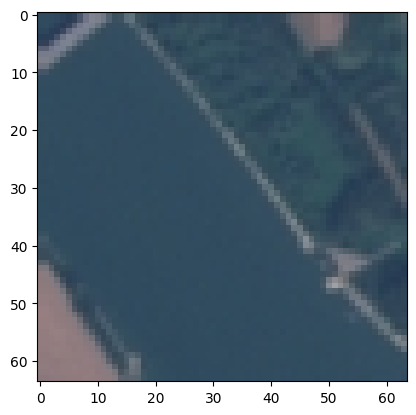

In [30]:
import random

from torch.utils.data import DataLoader

BATCH_SIZE = 16
DATA_DIR = "data/eurosat"

trainset = AutoEncoderDataset(f"{DATA_DIR}/train")
validationset = AutoEncoderDataset(f"{DATA_DIR}/validation")
testset = AutoEncoderDataset(f"{DATA_DIR}/test")
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_loader = DataLoader(validationset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
imshow(random.choice(trainset)[0])

## Queries
For each of the classes in the dataset, we are going to select one of the images in the test dataset and plot it. This images are the onew we are going to use to find similar images in the validation dataset.

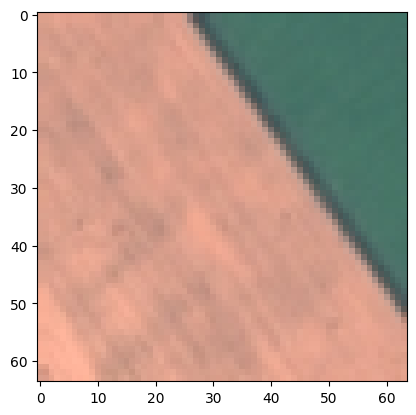

In [4]:
QUERY_1_IDX = 1
imshow(testset[QUERY_1_IDX][0])

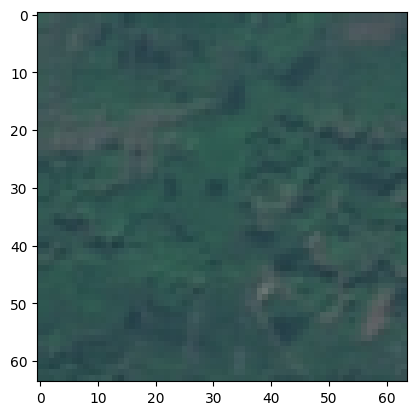

In [5]:
QUERY_2_IDX = 2
imshow(testset[QUERY_2_IDX][0])

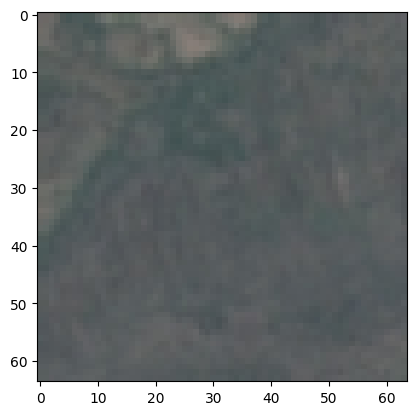

In [6]:
QUERY_3_IDX = 4
imshow(testset[QUERY_3_IDX][0])

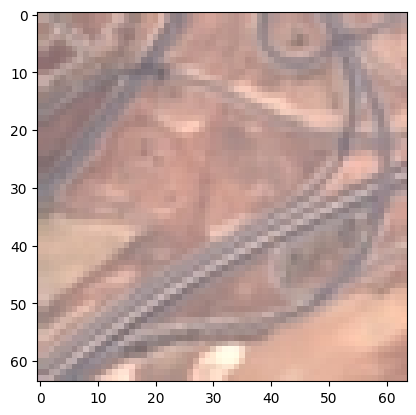

In [7]:
QUERY_4_IDX = 7
imshow(testset[QUERY_4_IDX][0])

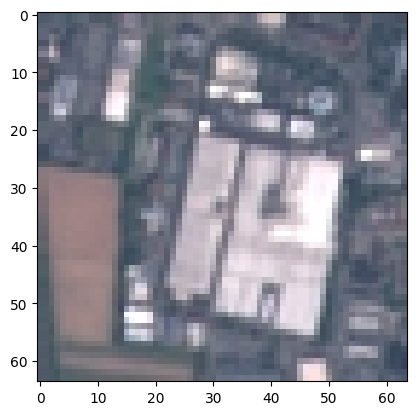

In [8]:
QUERY_5_IDX = 8
imshow(testset[QUERY_5_IDX][0])

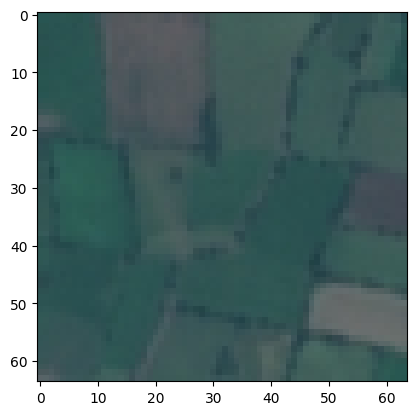

In [9]:
QUERY_6_IDX = 10
imshow(testset[QUERY_6_IDX][0])

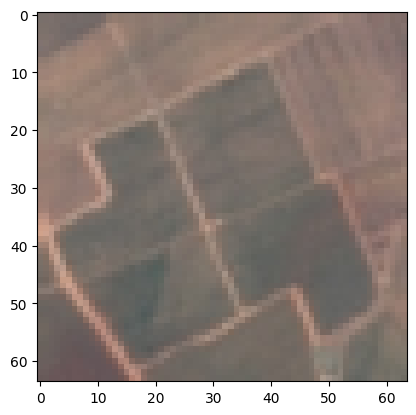

In [10]:
QUERY_7_IDX = 12
imshow(testset[QUERY_7_IDX][0])

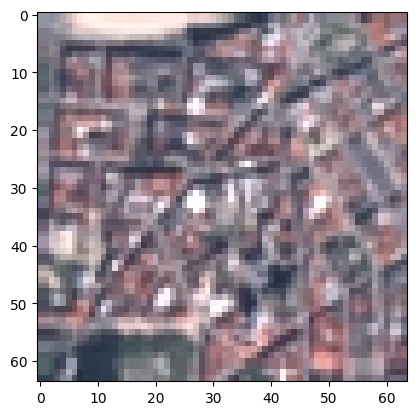

In [11]:
QUERY_8_IDX = 14
imshow(testset[QUERY_8_IDX][0])

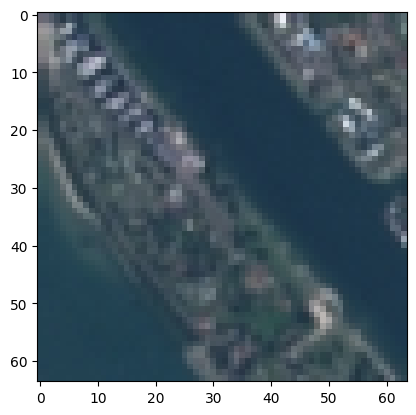

In [12]:
QUERY_9_IDX = 16
imshow(testset[QUERY_9_IDX][0])

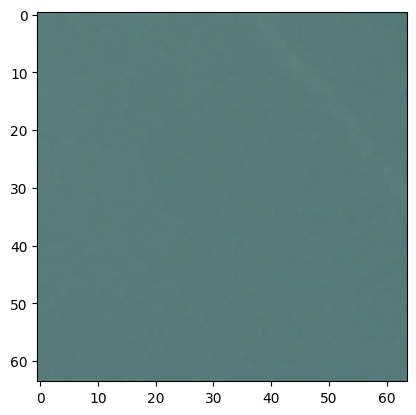

In [13]:
QUERY_10_IDX = 18
imshow(testset[QUERY_10_IDX][0])

We'll use GPU to speed things up

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Loading and predicting with pretrained encoder
To have a comparison point, we are going to load the ResNet-50 encoder and load the weights of the model trained with the ImageNet dataset, available in `torchvision`. We can observe the architecture of the whole Autoencoder.

The encoder will output and embedding of shape (2,048)

In [15]:
from torchvision.models.resnet import ResNet50_Weights


autoencoder = ResNetAutoEncoder(pretrained_weights=ResNet50_Weights.IMAGENET1K_V1)
autoencoder = autoencoder.to(device)
print(autoencoder)

ResNetAutoEncoder(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


We are going to generate the embeddings of each of the images in the dataset.

In [16]:
queries = []
autoencoder.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = autoencoder(images)
        queries.append(outputs[0].cpu())

Then we are going to generate and store the embeddings of each image in the validation set. To make the queries, we are going to use the K-Nearest Neighbours algorithm to get the top 5 most similar validation images to each test image.

In [17]:
from sklearn.neighbors import NearestNeighbors


image_embeddings = []
images = DataLoader(validationset, batch_size=1, shuffle=False, num_workers=2)
autoencoder.eval()
with torch.no_grad():
    for data in images:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = autoencoder(images)
        image_embeddings.append(outputs[0].cpu())
print(image_embeddings[0].shape)
print(image_embeddings[0])
neigh = NearestNeighbors(n_neighbors=5, algorithm="brute")
neigh.fit(image_embeddings)
distances, indices = neigh.kneighbors(queries)
print(indices)

torch.Size([2048])
tensor([0.0000, 0.2748, 0.4062,  ..., 0.0000, 0.0000, 0.1772])
[[4746 3041 2938   28 6478]
 [ 158  295  801   92  667]
 [1378 1736 1076  963 2555]
 [1160 1687 1381 1440 2256]
 [2035 1686 2293 1221 1829]
 [2644 2613 2442 2562 5083]
 [2943 3106 2709 3058 3366]
 [2717 3105 5477 3063 4906]
 [3885 3863 3996 4127 3552]
 [3864 3802 3639 5418 3962]
 [4535 4718 4249 4314 4512]
 [4379 2056 4782 4362 4500]
 [5021    1 4480  235  778]
 [5368 5110 4838 5465 3432]
 [5643 6372 5902 6365 5586]
 [3476 6001 2654 5745 3232]
 [7153 6458 7043 7169 7117]
 [6527   68 7072  232 2723]
 [7295 7287 7477 7421 7794]
 [7349 7458 1412 1096 1554]]


## Pretrained weights result

Based on the title of the image, the resulting image is very accurate as all of them belong to the same class **AnnualCrop**

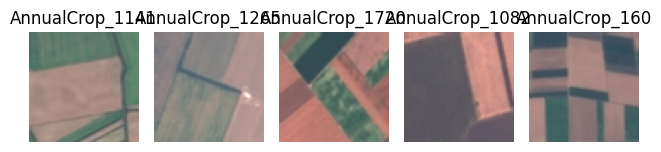

In [18]:
plot_images(trainset, indices[QUERY_1_IDX])

The second query was a forest. Only the last result belongs to the same class, the other results are very different. They don't even have the same colours.

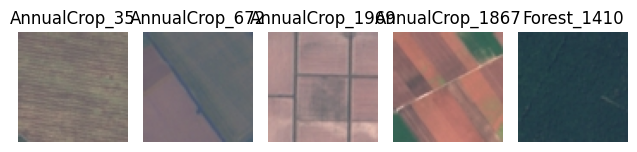

In [19]:
plot_images(trainset, indices[QUERY_2_IDX])

Something similar happend to the query of the **Herbaceous vegetation** colors and textures don't match.

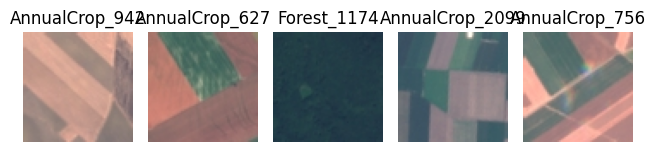

In [20]:
plot_images(trainset, indices[QUERY_3_IDX])

The query for a highway didn't yield good results neither. Only the last result could match the textures and results of the query image.

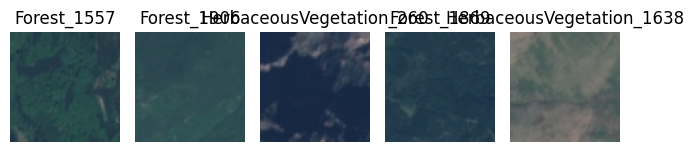

In [21]:
plot_images(trainset, indices[QUERY_4_IDX])

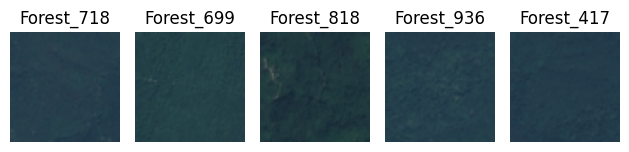

In [22]:
plot_images(trainset, indices[QUERY_5_IDX])

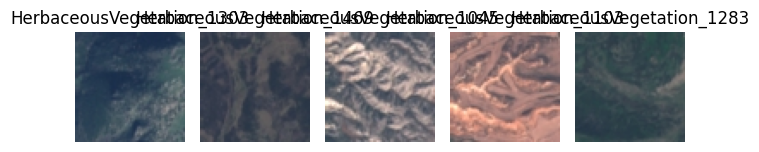

In [23]:
plot_images(trainset, indices[QUERY_6_IDX])

The query for **permanent crop** which was an image containing shapes with almost 90° angles, straight lines and clear borders gave better results. Although the results don't belong to the same class, visually the images are similar and have the same characteristics.

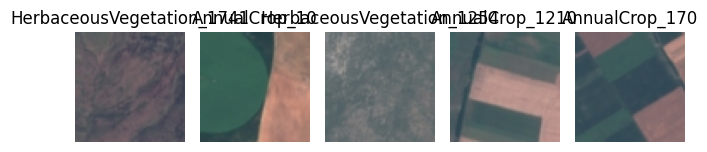

In [24]:
plot_images(trainset, indices[QUERY_7_IDX])

The query for *residential* had interesting results: the image contains streets and roads which can be seen as lines with a well defined border. The results, although are not from the same class, have those same lines that look like roads.

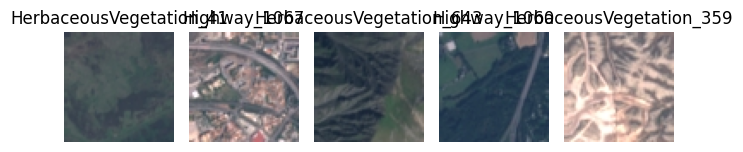

In [25]:
plot_images(trainset, indices[QUERY_8_IDX])

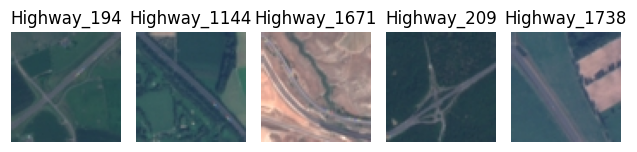

In [26]:
plot_images(trainset, indices[QUERY_9_IDX])

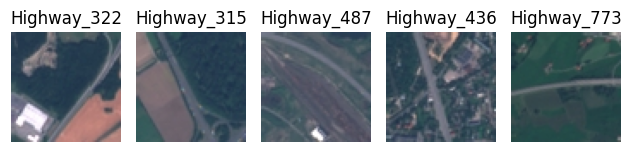

In [27]:
plot_images(trainset, indices[QUERY_10_IDX])

## Training Autoencoder

In [32]:
from torchvision.models.resnet import ResNet50_Weights


autoencoder = ResNetAutoEncoder(pretrained_weights=ResNet50_Weights.IMAGENET1K_V1)
autoencoder = autoencoder.to(device)

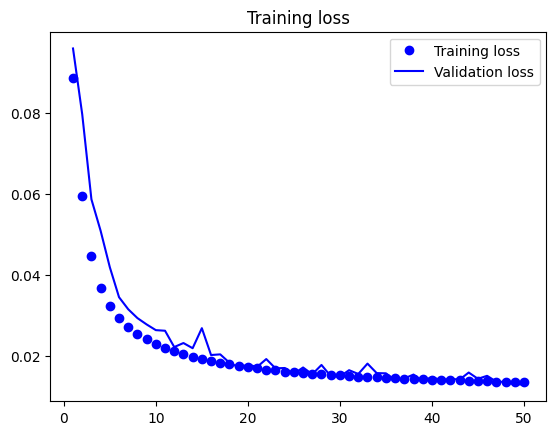

In [33]:
from torch.nn import MSELoss
from torch.optim import SGD


EPOCHS = 50
LEARNING_RATE = 0.0001#0.00001

criterion = MSELoss()
optimizer = SGD(autoencoder.parameters(), lr=LEARNING_RATE, momentum=0.9)
train_loss = []
validation_loss = []
for epoch in range(1, EPOCHS + 1):
    running_loss = 0
    autoencoder.train()
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = autoencoder(images, False)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    val_loss = 0
    autoencoder.eval()
    with torch.no_grad():
        for i, data in enumerate(validation_loader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = autoencoder(images, False)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss = val_loss / len(validation_loader)
    epoch_loss = running_loss / len(train_loader)
    train_loss.append(epoch_loss)
    validation_loss.append(val_loss)
print_loss_history(train_loss, validation_loss)

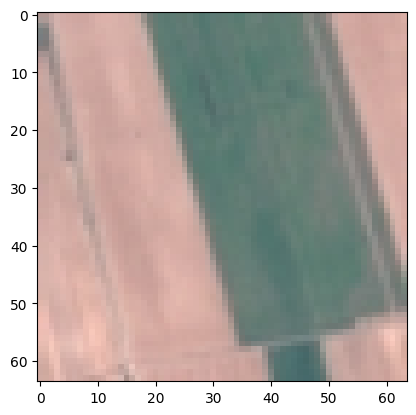

In [34]:
imshow(validationset[27][0])

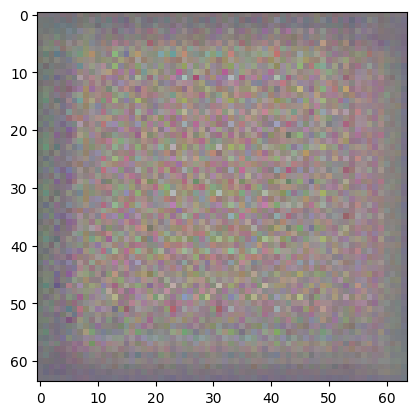

In [35]:
autoencoder.eval()
with torch.no_grad():
    validation_image, _ = validationset[27]
    validation_image = validation_image.to(device)
    outputs = autoencoder(images, False)[0]
imshow(outputs.cpu())

In [36]:
from sklearn.neighbors import NearestNeighbors


image_embeddings = []
images = DataLoader(trainset, batch_size=1, shuffle=False, num_workers=2)
autoencoder.eval()
with torch.no_grad():
    for data in images:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = autoencoder(images)
        image_embeddings.append(outputs[0].cpu())
print(image_embeddings[0].shape)
print(image_embeddings[0])
neigh = NearestNeighbors(n_neighbors=5, algorithm="brute")
neigh.fit(image_embeddings)
distances, indices = neigh.kneighbors(queries)
print(indices)

torch.Size([2048])
tensor([4.7232e-01, 1.1023e+00, 1.9966e-02,  ..., 4.0996e-01, 3.6996e-05,
        0.0000e+00])
[[15776 15571  7666  7495  7338]
 [ 1748   787 17820  1968    80]
 [18740 16904  2978 17213 18801]
 [ 1673 17213 16904 18631 18801]
 [17213 18631 16904 17512 18747]
 [15179 16480 12894 10054  6183]
 [11275 11641  9764 12488  6768]
 [ 7157 15661 12488  7123  6532]
 [ 3822  3332 11093 17319 18209]
 [10713  9819 10050 10394 10958]
 [10143 10912 11028 11109 10745]
 [10745 18747 16904 18734 17213]
 [ 1639  1673 11080 17599 15913]
 [10974 15975 16252 14330 12125]
 [ 6619  6430 13768  8023  9963]
 [ 5996  5968  6423 15987 16462]
 [ 6650  7447  6769  6795  8165]
 [12596  7157  7218 15174 15337]
 [16904 18740 18565  3741 17915]
 [16904 18801 17213 16986 18565]]


In [37]:
queries = []
autoencoder.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = autoencoder(images)
        queries.append(outputs[0].cpu())

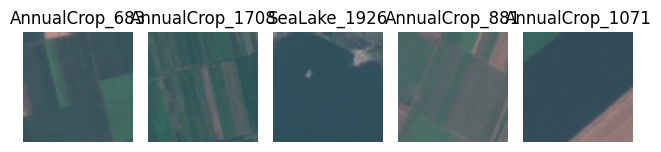

In [38]:
plot_images(trainset, indices[QUERY_1_IDX])

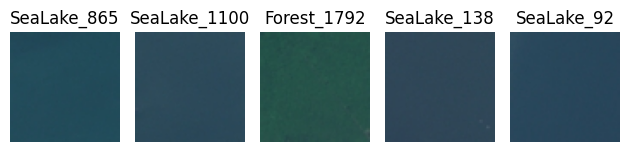

In [39]:
plot_images(trainset, indices[QUERY_2_IDX])

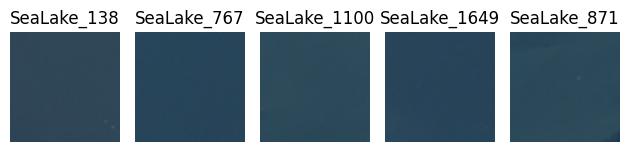

In [40]:
plot_images(trainset, indices[QUERY_3_IDX])

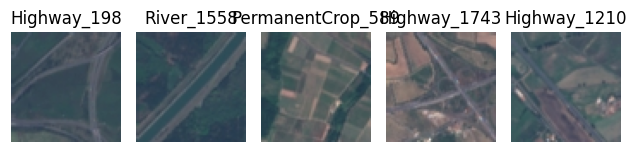

In [41]:
plot_images(trainset, indices[QUERY_4_IDX])

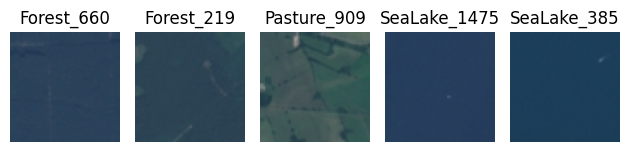

In [42]:
plot_images(trainset, indices[QUERY_5_IDX])

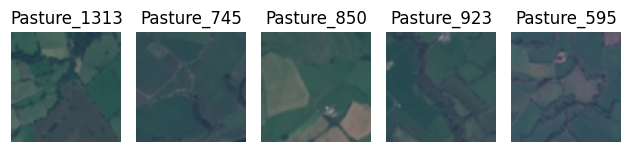

In [43]:
plot_images(trainset, indices[QUERY_6_IDX])

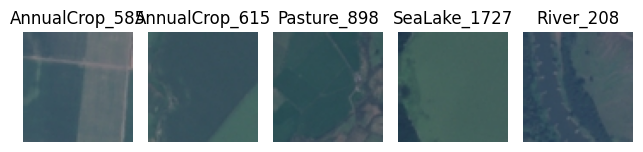

In [44]:
plot_images(trainset, indices[QUERY_7_IDX])

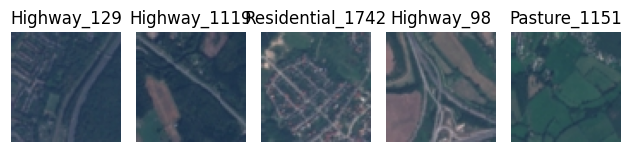

In [45]:
plot_images(trainset, indices[QUERY_8_IDX])

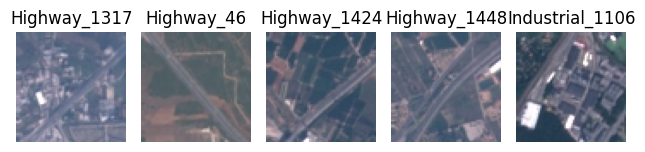

In [46]:
plot_images(trainset, indices[QUERY_9_IDX])

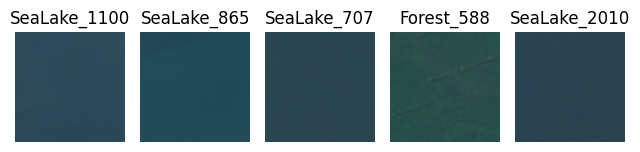

In [47]:
plot_images(trainset, indices[QUERY_10_IDX])